# Minding the p's, d's and q's of ARIMA

The first thing to note is that analyzing ACF and PACF plots is a bit of a forgotten art. It's a skill that should be learned, but honestly, it's rarely used anymore. The reason is that modern computational power have enabled better tooling. For instance, the auto_arima function in the pmdarima library is a great tool for automatically selecting the best ARIMA model. It uses a stepwise approach to search through the model space and find the best model based on the AIC. The AIC is a measure of the quality of a model, and the lower the AIC, the better the model. The auto_arima function will search through the model space and find the model with the lowest AIC. It's a great tool for quickly finding the best ARIMA model.

That said, it's good to understand the basics of statistically choosing the parameters. The ARIMA model is a linear model that uses autoregressive (AR), differencing (I), and moving average (MA) components to model time series data. 

### Autoregressive (AR) component
The AR component models the relationship between an observation and a number of lagged observations. 

### Moving Average (MA) component
The MA component models the relationship between an observation and a number of lagged forecast errors. 

### Differencing (I) component
The I component models the differencing of the time series data to make it stationary. This can be calculated as the difference between the observation at time t and the observation at time t-1. 

$$ y'_t = y_t - y_{t-1} $$

### Terms vs Orders
The ARIMA model is written as $ARIMA(p, d, q)$. 

The way that we write the terms are different to the variable names that are used to represent the order (degree) of the terms. 
* The AR term is written as $AR(p)$, where $p$ is the number of lagged observations. 
* The MA term is written as $MA(q)$, where $q$ is the number of lagged forecast errors. 
* The I term is written as $I(d)$, where $d$ is the number of differences.

In mathematical terms, every "term" is a function and the p, d, and q are the order variables of the functions.

# Let's look at some time series data

In [1]:
from IPython.display import Markdown, display

import ts_utils as tsu
import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn import set_config
set_config(transform_output="pandas")

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError()

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
data_path = Path('./data')



# Load and Inspect the Data

In [2]:
# Load the famous airline passengers dataset
df = load_airline().astype(int).to_frame()
df.index = df.index.to_timestamp()
df.index.name = "date"
df

,Number of airline passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of airline passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


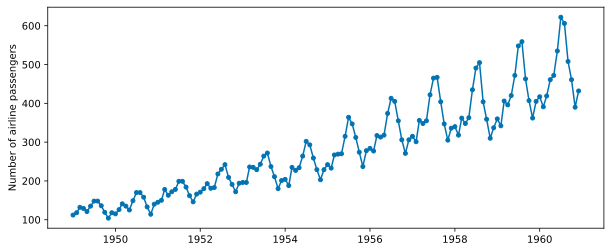

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_series(df, ax=ax)
plt.show()

# Some Observations

1. The **mean of the data** is rising over time (aka trend), which suggests that it is not stationary.
2. The data has a clear **seasonal** pattern, which suggests that it is not stationary. (Look at the peaks which occur at regular intervals - about every 12 months)
3. The **variance of the data** is increasing over time, which suggests that it is not stationary. The variance can be seen by the distance between the peaks and troughs of the data which is increasing over time.

## The Moving Average shows the Mean is increasing over time

In [5]:
df

,Number of airline passengers
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


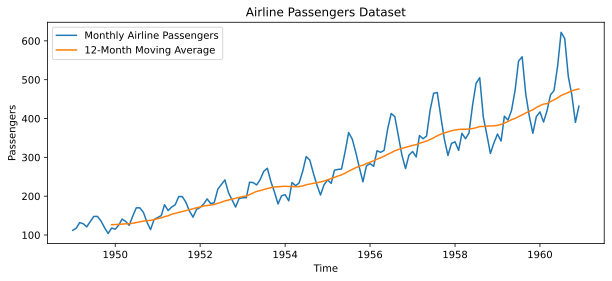

In [6]:
# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(df, label="Monthly Airline Passengers")
plt.plot(df.rolling(window=12).mean(), label="12-Month Moving Average")

plt.title("Airline Passengers Dataset")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()

## Showing increasing variance over time

### The Bounding lines show increasing variance over time

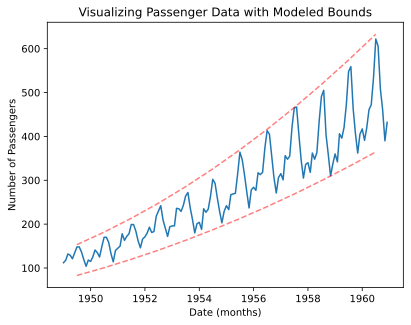

In [7]:
year_groups = df.groupby(pd.Grouper(freq="YE"))
minima = year_groups.min()["Number of airline passengers"]
maxima = year_groups.max()["Number of airline passengers"]

# for viz only: recenter each datapoint around the center of the month
idx = maxima.index - pd.DateOffset(months=6)

# build a regressor model for the max/min data
predmin = tsu.get_polyregr_pred(minima, degree=2)
predmax = tsu.get_polyregr_pred(maxima, degree=2)

fig, ax = plt.subplots()
ax.set_title("Visualizing Passenger Data with Modeled Bounds")
ax.set_xlabel("Date (months)")
ax.set_ylabel("Number of Passengers")

ax.plot(df)
ax.plot(idx, predmin - 20, color="red", alpha=0.5, ls="--")
ax.plot(idx, predmax + 10, color="red", alpha=0.5, ls="--")

display(Markdown("### The Bounding lines show increasing variance over time"))
plt.show()

# Let's break down the yearly seasons

### The vertical lines show yearly seasonality

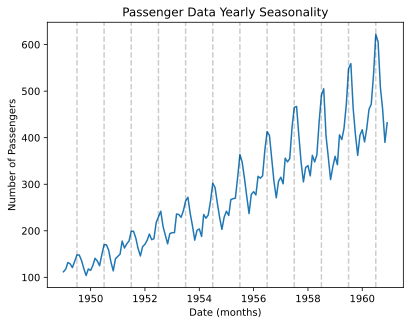

In [8]:
# plot the data with vertical lines every year
fig, ax = plt.subplots()
ax.set_title("Passenger Data Yearly Seasonality")
ax.set_xlabel("Date (months)")
ax.set_ylabel("Number of Passengers")

ax.plot(df)

# plot vertical lines at the "peak" of each year
for year in range(1949, 1961):
    ax.axvline(
        pd.to_datetime(str(year)) + pd.DateOffset(months=6),
        color="black",
        alpha=0.2,
        ls="--",
    )

display(Markdown("### The vertical lines show yearly seasonality"))
plt.show()

### Notice how each year has a similar shape

<Figure size 1000x800 with 0 Axes>

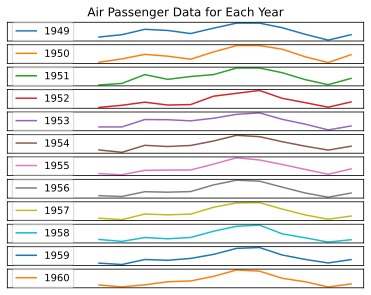

In [9]:
years = pd.DataFrame()
groups = df.groupby(pd.Grouper(freq="YE"))  # group by year

for name, group in groups:
    years[name.year] = group["Number of airline passengers"].values

plt.figure(figsize=(10, 8))
axs = years.plot(subplots=True, legend=False)
axs[0].set_title("Air Passenger Data for Each Year")

# loop through and customize each of the subplots
for ax in axs:
    ax.set_xlim(-4)  # make room for the legend.
    ax.legend(loc="center left")
    ax.tick_params(
        axis="both", bottom=None, labelbottom=None, left=None, labelleft=None
    )

display(Markdown("### Notice how each year has a similar shape"))
plt.show()

# Let's look at how the **variance** increases over time

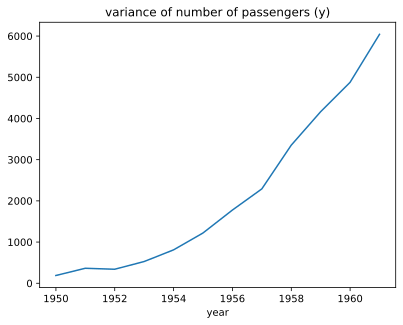

In [10]:
var = (
    df.copy()
    .resample("YE")
    .var()  # variance of num_passengers
    .rename(
        {"Number of airline passengers": "variance of number of passengers"},
        axis="columns",
    )
)
# display(var)

fig, ax = plt.subplots()
ax.set_title("variance of number of passengers (y)")
ax.set_xlabel("year")
ax.plot(var)
plt.show()

# Another way to look at the variance is to take the histogram

We notice that the histogram is skewed to the right.

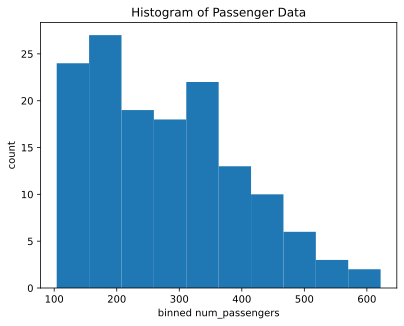

In [11]:
# plot histogram of passenger data
fig, ax = plt.subplots()
ax.set_title("Histogram of Passenger Data")
ax.set_xlabel("binned num_passengers")
ax.set_ylabel("count")
ax.hist(df)
plt.show()

## changing variance is hard for traditional models like ARIMA

So we need to do something about that.  Here we'll take the boxcox transform of the data to stabilize the variance. 



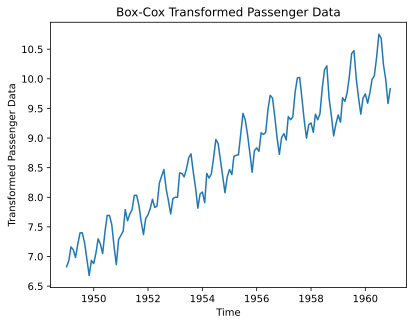

In [12]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

# create a box-cox transformer
bct = BoxCoxTransformer()

df_orig = df.copy()
df["Number of airline passengers"] = bct.fit_transform(df)

# plot the transformed data and the histogram
fig, ax = plt.subplots()
ax.set_title("Box-Cox Transformed Passenger Data")
ax.set_xlabel("Time")
ax.set_ylabel("Transformed Passenger Data")
ax.plot(df["Number of airline passengers"])
plt.show()

# Let's look at the variance plot and the histogram again

Notice that both the data plot and the variance plot are more linear. The histogram is also more symmetric.

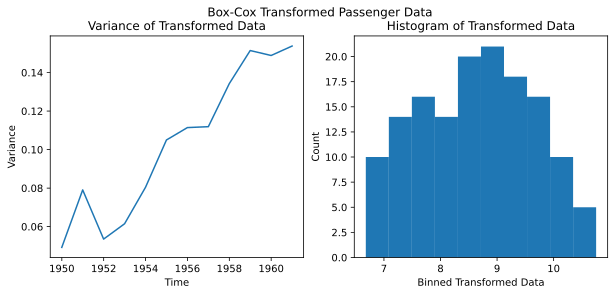

In [13]:
# plot the variance and the histogram of the transformed data side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot the variance of the transformed data
fig.suptitle("Box-Cox Transformed Passenger Data")
axs[0].set_title("Variance of Transformed Data")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Variance")
axs[0].plot(df.resample("YE").var())

# plot the histogram of the transformed data
axs[1].set_title("Histogram of Transformed Data")
axs[1].set_xlabel("Binned Transformed Data")
axs[1].set_ylabel("Count")
axs[1].hist(df["Number of airline passengers"])
plt.show()

# Changing variance is hard for traditional models like ARIMA 
...so we keep the transformed data

Increasing mean is also difficult to analyze.  ARIMA has the "I" term to handle this - but to analyze properly with ACF and PACF, we will need to take the difference of the data manually.

# ACF and PACF plot of the box-cox transformed data WITHOUT taking the difference.

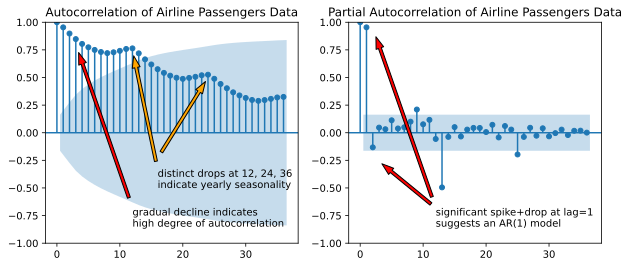

In [14]:
# plot the acf and pact side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot the acf
plot_acf(df, lags=36, ax=axs[0])
axs[0].set_title("Autocorrelation of Airline Passengers Data")

# add annotation arrow and text to lag=3
axs[0].annotate(
    "gradual decline indicates \nhigh degree of autocorrelation",
    xy=(3, 0.8),
    xytext=(12, -0.85),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

# add annotation arrow and text to lag=12
axs[0].annotate(
    "distinct drops at 12, 24, 36\nindicate yearly seasonality",
    xy=(12, 0.75),
    xytext=(16, -0.5),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

# just add an arrow to lag=12
axs[0].annotate(
    "\n\n",
    xy=(24, 0.5),
    xytext=(16, -0.5),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

# plot the pacf
plot_pacf(df, lags=36, ax=axs[1])
axs[1].set_title("Partial Autocorrelation of Airline Passengers Data")

# add an arrow to lag=1
axs[1].annotate(
    "significant spike+drop at lag=1\nsuggests an AR(1) model",
    xy=(2, 0.95),
    xytext=(12, -0.85),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)
axs[1].annotate(
    "\n",
    xy=(3, -0.26),
    xytext=(12, -0.85),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

plt.show()

# Taking the ACF and PACF of the variance and mean stabilized data
... makes the data stationary and ready for ARIMA analysis.
Note: We have not taken the difference for seasonality yet.  So this is just to look at the data. We can't conclude anyhthing major from this yet.

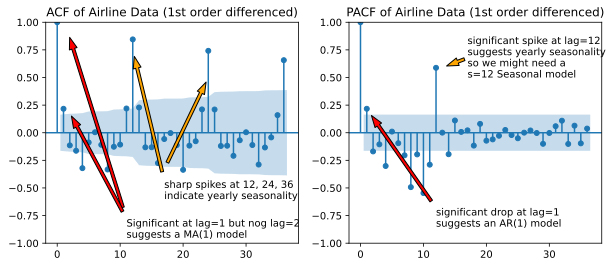

In [15]:
# plot the acf and pact side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

df_diff = df.diff().dropna()

# plot the acf
plot_acf(df_diff, lags=36, ax=axs[0])
axs[0].set_title("ACF of Airline Data (1st order differenced)")

# add annotation arrow and text to lag=0,1
axs[0].annotate(
    "Significant at lag=1 but nog lag=2\nsuggests a MA(1) model",
    xy=(1.5, 0.95),
    xytext=(11, -0.95),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

axs[0].annotate(
    "\n",
    xy=(1.8, 0.2),
    xytext=(11, -0.95),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

# add annotation arrow and text to lag=12
axs[0].annotate(
    "sharp spikes at 12, 24, 36\nindicate yearly seasonality",
    xy=(12, 0.75),
    xytext=(17, -0.6),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

# just add an arrow to lag=12
axs[0].annotate(
    "\n\n",
    xy=(24, 0.5),
    xytext=(17, -0.6),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

# plot the pacf
plot_pacf(df_diff, lags=36, ax=axs[1])
axs[1].set_title("PACF of Airline Data (1st order differenced)")

# add an arrow to lag=1
axs[1].annotate(
    "significant drop at lag=1\nsuggests an AR(1) model",
    xy=(1.2, 0.2),
    xytext=(12, -0.85),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

# add arrows to lag=1, lag=12 and lag=24
axs[1].annotate(
    "significant spike at lag=12\nsuggests yearly seasonality\nso we might need a\ns=12 Seasonal model",
    xy=(13.5, 0.6),
    xytext=(17, 0.5),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

plt.show()

## ACF and PACF of box-cox, season corrected and seasonality reduced data

* We take the Box-Cox transform to remove the changing variance
* We take the diff(12) to remove the seasonal period of 12 months
* We take the diff(1) to remove the increasing mean and make it fully stationary

**Note: This is the main analysis for the SARIMA parameters.**

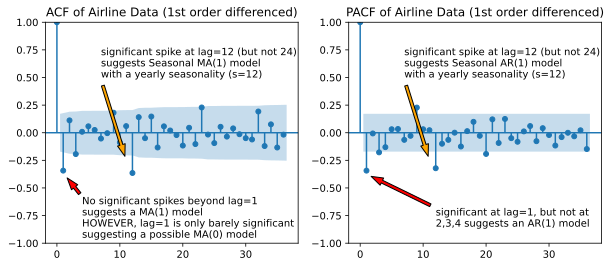

In [16]:
# plot the acf and pact side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

df_diff = df.diff(12).dropna()  # for seasonal differencing
df_diff = df_diff.diff().dropna()  # to make it stationary

# plot the acf
plot_acf(df_diff, lags=36, ax=axs[0])
axs[0].set_title("ACF of Airline Data (1st order differenced)")

# add annotation arrow and text to lag=0,1
axs[0].annotate(
    "No significant spikes beyond lag=1\nsuggests a MA(1) model\nHOWEVER, lag=1 is only barely significant\nsuggesting a possible MA(0) model",
    xy=(1.5, -0.4),
    xytext=(4, -0.95),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

axs[0].annotate(
    "significant spike at lag=12 (but not 24)\nsuggests Seasonal MA(1) model\nwith a yearly seasonality (s=12)",
    xy=(11, -0.25),
    xytext=(7, 0.5),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

# plot the pacf
plot_pacf(df_diff, lags=36, ax=axs[1])
axs[1].set_title("PACF of Airline Data (1st order differenced)")

# add an arrow to lag=1
axs[1].annotate(
    "significant at lag=1, but not at\n2,3,4 suggests an AR(1) model",
    xy=(1.2, -0.38),
    xytext=(12, -0.85),
    arrowprops=dict(facecolor="red", shrink=0.05, width=3, headwidth=8),
)

# add arrows to lag=1, lag=12 and lag=24
axs[1].annotate(
    "significant spike at lag=12 (but not 24)\nsuggests Seasonal AR(1) model\nwith a yearly seasonality (s=12)",
    xy=(11, -0.25),
    xytext=(7, 0.5),
    arrowprops=dict(facecolor="orange", shrink=0.05, width=3, headwidth=8),
)

plt.show()

# we can now consider an ARIMA Model with the following variables:

* p = 1 (AR term)
* d = 1 (I term)
* q = 1 (MA term)
* P = 1 (Seasonal AR term)
* D = 1 (Seasonal I term)
* Q = 1 (Seasonal MA term)
* s = 12 (Seasonal period)

### Alternatively, we can use:
* p = 1 (AR term)
* d = 1 (I term)
* q = 0 (MA term)
* P = 1 (Seasonal AR term)
* D = 1 (Seasonal I term)
* Q = 0 (Seasonal MA term)
* s = 12 (Seasonal period)

# Fitting the SARIMA model using (1,1,0) and (1,1,0,12)

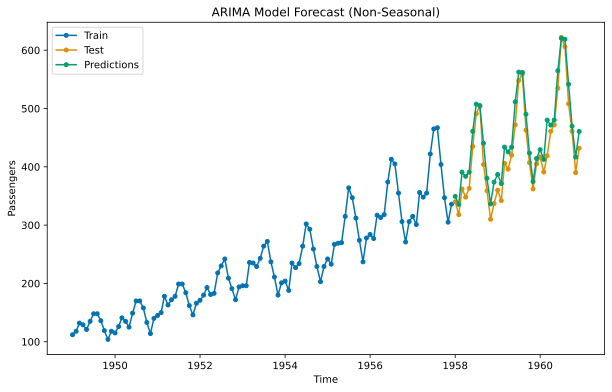

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  96.963
Date:                            Sun, 22 Dec 2024   AIC                           -185.925
Time:                                    22:22:42   BIC                           -175.710
Sample:                                01-31-1949   HQIC                          -181.797
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.009      0.117      0.907      -0.017       0.020
ar.L1         -0.3572      0.086     -4.162      0.000      -0.525      -0.189
ar.S.L12      -0.4370      0.079     -5.543      0.000      -0.592      -0.282
sigma2         0.0074      0.001      6.698      0.000       0.005       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.90   Prob(JB):                         0.66
Heteroskedasticity (H):               0.39   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Mean Abs Perc Error: 5.08%

In [17]:
# Load the AirPassengers dataset
airline_data = load_airline().to_frame()

from sktime.transformations.series.boxcox import BoxCoxTransformer

bct = BoxCoxTransformer()
airline_data["Number of airline passengers"] = bct.fit_transform(
    airline_data["Number of airline passengers"]
)

# Split the data into train and test sets (last 2 years for testing)
train, test = temporal_train_test_split(
    airline_data["Number of airline passengers"], test_size=36
)

# Fit ARIMA model without seasonal components
model = ARIMA((1, 1, 0), (1, 1, 0, 12), suppress_warnings=True)
model.fit(train)

# Forecast the last 2 years
fh = np.arange(1, len(test) + 1)  # Forecasting horizon
predictions = model.predict(fh)


# inverse diff
# predictions = np.cumsum(predictions)
# test = np.cumsum(test)
# train = np.cumsum(train)

# inverse box-cox
predictions = bct.inverse_transform(predictions)
test = bct.inverse_transform(test)
train = bct.inverse_transform(train)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
plot_series(train, test, predictions, labels=["Train", "Test", "Predictions"], ax=ax)

plt.title("ARIMA Model Forecast (Non-Seasonal)")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()

display(model.summary())

# mean absolute percentage error
display(Markdown(f"### Mean Abs Perc Error: {mape(predictions, test)*100:.2f}%"))

## Fitting the SARIMA model using (1,1,1) and (1,1,1,12)

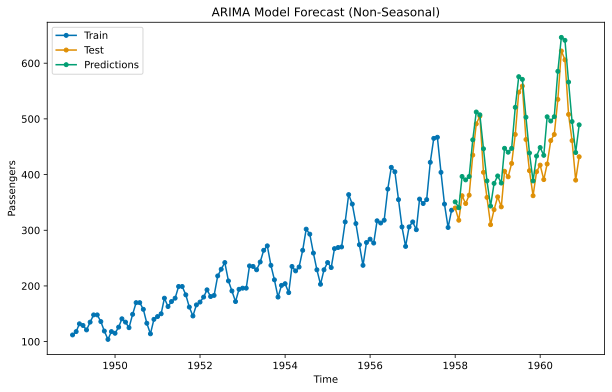

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 100.010
Date:                            Sun, 22 Dec 2024   AIC                           -188.020
Time:                                    22:22:43   BIC                           -172.697
Sample:                                01-31-1949   HQIC                          -181.828
                                     - 12-31-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.186      0.852      -0.004       0.004
ar.L1          0.3010      0.251      1.199      0.231      -0.191       0.793
ma.L1         -0.6413      0.215     -2.984      0.003      -1.063      -0.220
ar.S.L12      -0.0771      0.266     -0.290      0.772      -0.598       0.444
ma.S.L12      -0.4870      0.286     -1.702      0.089      -1.048       0.074
sigma2         0.0068      0.001      6.479      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.78   Prob(JB):                         0.32
Heteroskedasticity (H):               0.39   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Mean Abs Perc Error: 7.87%

In [18]:
# Load the AirPassengers dataset
airline_data = load_airline().to_frame()

from sktime.transformations.series.boxcox import BoxCoxTransformer

bct = BoxCoxTransformer()
airline_data["Number of airline passengers"] = bct.fit_transform(
    airline_data["Number of airline passengers"]
)

# Split the data into train and test sets (last 2 years for testing)
train, test = temporal_train_test_split(
    airline_data["Number of airline passengers"], test_size=36
)

# Fit ARIMA model without seasonal components
model = ARIMA((1, 1, 1), (1, 1, 1, 12), suppress_warnings=True)
model.fit(train)

# Forecast the last 2 years
fh = np.arange(1, len(test) + 1)  # Forecasting horizon
predictions = model.predict(fh)


# inverse diff
# predictions = np.cumsum(predictions)
# test = np.cumsum(test)
# train = np.cumsum(train)

# inverse box-cox
predictions = bct.inverse_transform(predictions)
test = bct.inverse_transform(test)
train = bct.inverse_transform(train)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
plot_series(train, test, predictions, labels=["Train", "Test", "Predictions"], ax=ax)

plt.title("ARIMA Model Forecast (Non-Seasonal)")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()

display(model.summary())

# mean absolute percentage error
display(Markdown(f"### Mean Abs Perc Error: {mape(predictions, test)*100:.2f}%"))

# Analyzing the results

**Using AIC to compare the two models:**
* The model with (1,1,0) and (1,1,0,12) has an AIC of -185.925 
* The model with (1,1,1) and (1,1,1,12) has an AIC of -188.020 
* The model with the lower AIC is the better model. 
* In this case, the model with (1,1,1) and (1,1,1,12) is the (slightly) better model.

**Using MAPE on the predictions:**
* The model with (1,1,0) and (1,1,0,12) has a MAPE of 5.08%
* The model with (1,1,1) and (1,1,1,12) has a MAPE of 7.87%
* The model with the lower MAPE forecasted this period more accurately.
* For this forecast period, the model with (1,1,0) and (1,1,0,12) looks to be the better model.

***The differences in AIC are very small, but the MAPE is quite different. The AIC is based on all the data while the MAPE is based on a single forecast period. I would rely on the AIC more than the MAPE. However, I would conclude that these two models are almost equivalant.***

# Using AutoARIMA is a more modern way to find the best model

Using AutoARIMA is similar to performing a grid search over the hyperparameters. It will search through the model space and find the model with the lowest AIC. It's a great tool for quickly finding the best ARIMA model.

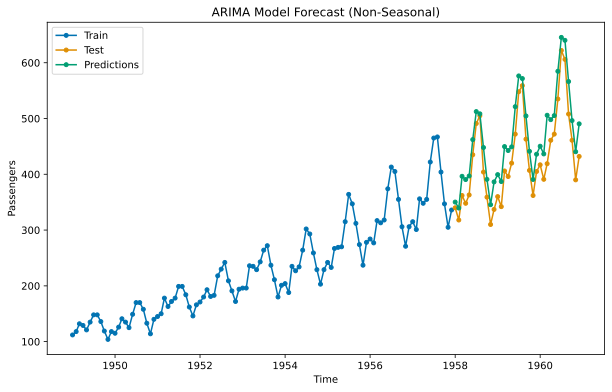

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 105.023
Date:                              Sun, 22 Dec 2024   AIC                           -200.047
Time:                                      22:23:08   BIC                           -187.225
Sample:                                  01-31-1949   HQIC                          -194.864
                                       - 12-31-1957                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0725      0.030      2.433      0.015       0.014       0.131
ar.L1          0.5650      0.103      5.487      0.000       0.363       0.767
ar.L2          0.1867      0.101      1.851      0.064      -0.011       0.384
ma.S.L12      -0.5651      0.119     -4.731      0.000      -0.799      -0.331
sigma2         0.0062      0.001      7.155      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.21
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               0.37   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Mean Abs Perc Error: 8.10%

In [19]:
# Load the AirPassengers dataset
airline_data = load_airline().to_frame()

from sktime.transformations.series.boxcox import BoxCoxTransformer

bct = BoxCoxTransformer()
airline_data["Number of airline passengers"] = bct.fit_transform(
    airline_data["Number of airline passengers"]
)

# Split the data into train and test sets (last 2 years for testing)
train, test = temporal_train_test_split(
    airline_data["Number of airline passengers"], test_size=36
)

# Fit ARIMA model without seasonal components
model = AutoARIMA(seasonal=True, sp=12, suppress_warnings=True)
model.fit(train)

# Forecast the last 2 years
fh = np.arange(1, len(test) + 1)  # Forecasting horizon
predictions = model.predict(fh)


# inverse diff
# predictions = np.cumsum(predictions)
# test = np.cumsum(test)
# train = np.cumsum(train)

# inverse box-cox
predictions = bct.inverse_transform(predictions)
test = bct.inverse_transform(test)
train = bct.inverse_transform(train)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
plot_series(train, test, predictions, labels=["Train", "Test", "Predictions"], ax=ax)

plt.title("ARIMA Model Forecast (Non-Seasonal)")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()

display(model.summary())

# mean absolute percentage error
display(Markdown(f"### Mean Abs Perc Error: {mape(predictions, test)*100:.2f}%"))

# Conclusion: AutoARIMA finds a better model that we did with ACF and PACF

* The AIC of -200.023 is the lowest yet so this model (2,0,0) and (0,1,1,12) is the best model.
* The MAPE of 8.10% isn't a good showing for this forecast period, but again, I'd stick with the lower AIC (this model) when picking a model that will generalize better.
* The fact that AutoARIMA explicitly chooses a model by looking at the AIC is slightly concerning since we are using the AIC to measure the performance of the models. 

